In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv("../../data/sierraleone-bumbuna.csv")

In [4]:
from scipy.stats import zscore

cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols_to_check].apply(zscore)  # Compute Z-scores

# Flag rows where any |Z| > 3 (considered outliers)
outlier_flags = (z_scores.abs() > 3)
df['is_outlier'] = outlier_flags.any(axis=1)  # Mark True if any column exceeds Z=3

print(f"Total outliers detected: {df['is_outlier'].sum()}")

Total outliers detected: 16292


In [5]:
for col in cols_to_check:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())
df_cleaned_seralleone = df[~df['is_outlier']].drop(columns='is_outlier')

In [6]:
benin_df = pd.read_csv('data/benin_clean.csv')
togo_df = pd.read_csv('data/togo_clean.csv')
serraleone_df = df_cleaned_seralleone

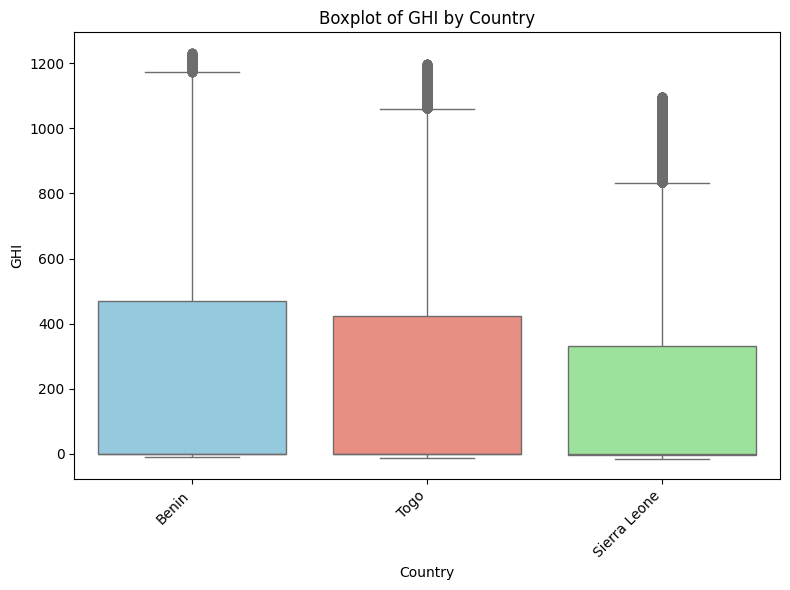

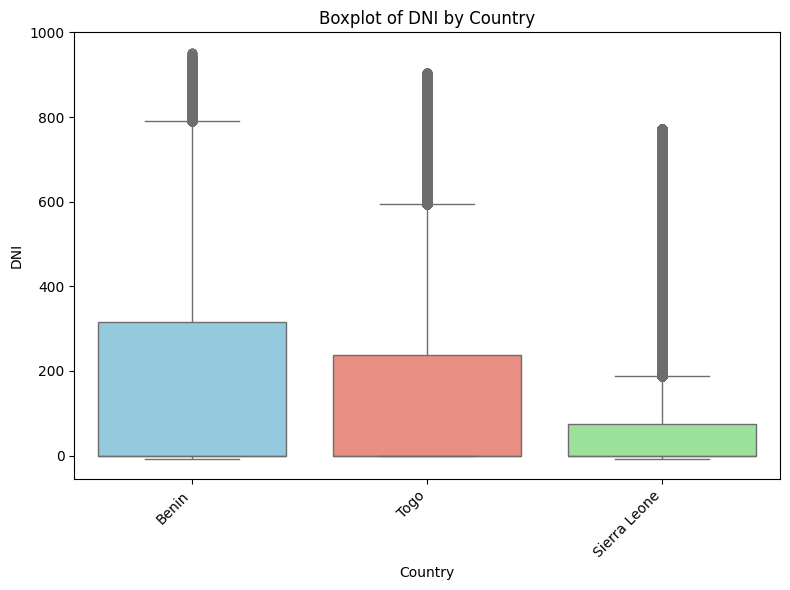

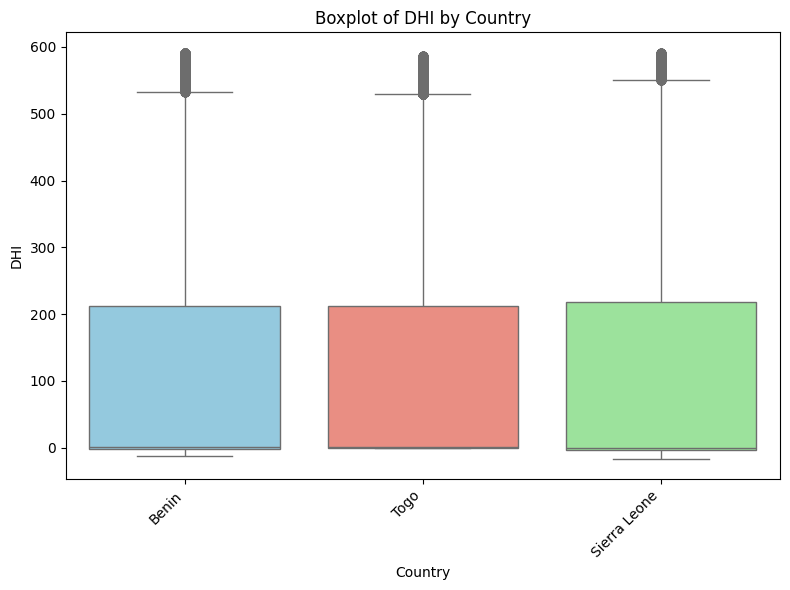

In [11]:
benin_df['Country'] = 'Benin'
togo_df['Country'] = 'Togo'
serraleone_df['Country'] = 'Sierra Leone'

# Concatenate all data
combined_df = pd.concat([benin_df, togo_df, serraleone_df], ignore_index=True)

# Metrics to plot
metrics = ['GHI', 'DNI', 'DHI']

palette = {
    'Benin': 'skyblue',
    'Togo': 'salmon',
    'Sierra Leone': 'lightgreen'
}

for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=combined_df, x='Country', y=metric, hue='Country', palette=palette, legend=False)
    plt.title(f'Boxplot of {metric} by Country')
    plt.xlabel('Country')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**📊 Comparing the Countries**

- **Benin** has the **highest median GHI** and also exhibits **greater variability** in its values.  
- It also records the **highest median DNI**, again showing **more variability** compared to the other countries.  
- In terms of **DHI**, the **three countries have nearly identical median values**, indicating **similar diffuse solar radiation levels**.

In [12]:
summary_data = {}

# Group by country and compute stats for selected columns
for country, df in combined_df.groupby('Country'):
    summary_data[country] = df[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).T

# Combine summaries into one table
summary_table = pd.concat(summary_data, axis=1)
summary_table.columns.name = 'Country'  # Optional: name the columns index

print("\nSummary Table of GHI, DNI, DHI across Countries:")
print(summary_table)


Summary Table of GHI, DNI, DHI across Countries:
          Benin                    Sierra Leone                     \
           mean median         std         mean median         std   
GHI  236.234508    0.7  328.288787   185.000024   -0.4  279.019460   
DNI  166.896673   -0.1  262.081997   104.128943   -0.1  200.954182   
DHI  111.656477    0.5  153.099749   108.104278   -0.6  153.691835   

           Togo                     
           mean median         std  
GHI  223.859675    0.5  317.306277  
DNI  147.975931    0.0  247.683690  
DHI  112.781249    1.5  151.571744  


**Analysis of variance(ANOVA)**
- Comparing Average GHI by Countries 

In [16]:
from scipy.stats import f_oneway, kruskal

# Extract GHI values by country
ghi_benin = combined_df[combined_df['Country'] == 'Benin']['GHI']
ghi_togo = combined_df[combined_df['Country'] == 'Togo']['GHI']
ghi_sierra = combined_df[combined_df['Country'] == 'Sierra Leone']['GHI']

# Run One-way ANOVA
anova_stat, anova_p = f_oneway(ghi_benin, ghi_togo, ghi_sierra)

# Run Kruskal–Wallis test
kruskal_stat, kruskal_p = kruskal(ghi_benin, ghi_togo, ghi_sierra)

# Print results
print("Statistical Testing on GHI values:")
print(f"One-way ANOVA p-value: {anova_p:.4f}")
print(f"Kruskal–Wallis p-value: {kruskal_p:.4f}")

Statistical Testing on GHI values:
One-way ANOVA p-value: 0.0000
Kruskal–Wallis p-value: 0.0000


In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data
ghi_values = combined_df['GHI']
countries = combined_df['Country']

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=ghi_values, groups=countries, alpha=0.05)

# Print results
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
       Benin Sierra Leone -51.2345   0.0  -52.664  -49.805   True
       Benin         Togo -12.3748   0.0 -13.7994 -10.9502   True
Sierra Leone         Togo  38.8597   0.0  37.4291  40.2902   True
-----------------------------------------------------------------


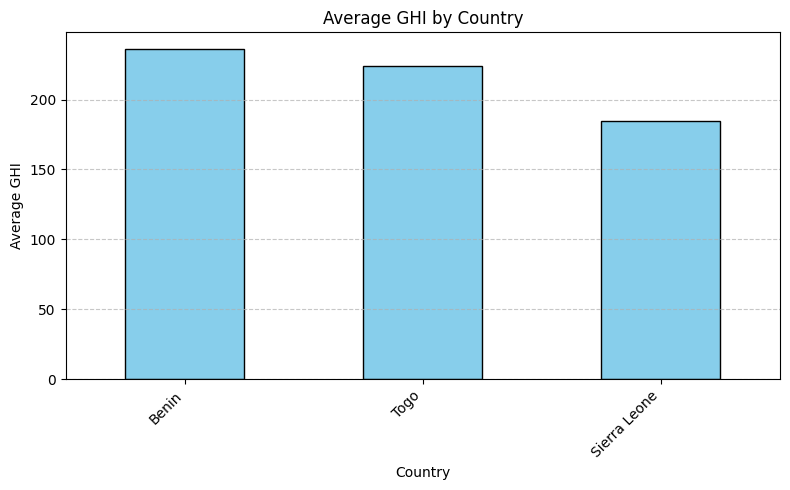

In [17]:
avg_ghi = combined_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
avg_ghi.plot(kind='bar', color='skyblue', edgecolor='black')

# Formatting
plt.title('Average GHI by Country')
plt.ylabel('Average GHI')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Average GHI Comparison**:  
- The average Global Horizontal Irradiance (GHI) in Benin is slightly higher than that observed in Togo and Sierra Leone. This difference is statistically significant as indicated in the pairwise comparison. This suggests that, on average, Benin receives more solar energy per square meter, potentially making it more favorable for solar energy generation.